### based on https://github.com/higgsfield/RL-Adventure and https://medium.com/swlh/introduction-to-reinforcement-learning-coding-sarsa-part-4-2d64d6e37617

[Double DQN @arxiv](https://arxiv.org/pdf/1509.06461.pdf)

In [1]:
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_AS)
resource.setrlimit(resource.RLIMIT_AS, (48 << 30, hard))
#resource.getrusage(resource.RUSAGE_SELF)

In [2]:
%matplotlib inline
import collections
import cv2
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import seaborn as sns
import time
import torch as t
from IPython.display import clear_output

In [3]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not belive how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]))

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = collections.deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]))

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(ResizeObservation, self).__init__(env)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0] // 2, shp[1] // 2, shp[2]))
        self.resize_to = (shp[1] // 2, shp[0] // 2)

    def observation(self, observation):
        return cv2.resize(observation, self.resize_to, interpolation=cv2.INTER_AREA)

SUFFIX = 'NoFrameskip-v4'
env = gym.make('Pong' + SUFFIX)
env = ResizeObservation(env)
env = ImageToPyTorch(env)
env = FrameStack(env, 4)

In [ ]:
USE_CUDA = t.cuda.is_available()# and False
device = t.device('cuda') if USE_CUDA else t.device('cpu')

In [ ]:
class Actor(object):
    def __init__(self, env, model, eps, eps_final, eps_steps, initial_explore=0):
        self.env = env
        self.model = model
        self.eps = eps
        self.eps_final = eps_final
        self.eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
        self.initial_explore = initial_explore
    
    def act(self, state):
        if self.initial_explore > 0:
            self.initial_explore -= 1
            return self.env.action_space.sample()
        self.eps = max(self.eps_final, self.eps * self.eps_decay)
        if random.random() < self.eps:
            return self.env.action_space.sample()
        self.model.eval()
        state = t.FloatTensor(np.array(state)).to(device)
        q = self.model(state)
        return q.argmax().item()

In [ ]:
class Model(t.nn.Module):
    def __init__(self, input_shape, input_frames, n_out):
        super().__init__()
        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(3 * input_frames, 32, kernel_size=8, stride=4),
            t.nn.PReLU(),
            t.nn.Conv2d(32, 64, kernel_size=4, stride=2),
            t.nn.PReLU(),
            t.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            t.nn.PReLU(),
        ) # -> 64 9 6
        cnn_fc = self.feature_size(self.cnn, input_shape)
        self.fc = t.nn.Sequential(
            t.nn.Linear(cnn_fc, 512),
            t.nn.PReLU(),
            t.nn.Linear(512, n_out)
        )
        self.apply(self.weights_init)
    
    def feature_size(self, cnn, shape):
        return cnn(t.zeros(1, *shape)).view(1, -1).size(1)

    def weights_init(self, m):
        if isinstance(m, t.nn.Linear):
            t.nn.init.kaiming_normal_(m.weight, 2)
            t.nn.init.constant_(m.bias, 0)
        elif isinstance(m, t.nn.Conv2d):
            t.nn.init.kaiming_normal_(m.weight, 2)
            t.nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        p = self.cnn(x)
        p = p.view(p.size(0), -1)
        return self.fc(p)

In [ ]:
class Replay(object):
    def __init__(self, maxlen):
        self.memory = np.empty(maxlen, dtype=np.object)
        self.index = 0
        self.count = 0

    def __len__(self):
        return self.count

    def add(self, state, action, next_state, reward, done):
        self.memory[self.index] = (state, action, next_state, reward, done)
        self.index = (self.index + 1) % len(self.memory)
        if self.count < len(self.memory):
            self.count += 1

    def sample(self, n, device):
        with t.no_grad():
            indices = np.random.randint(low=0, high=self.count, size=n)
            samples = zip(*list(self.memory[indices]))
            states, actions, next_states, rewards, masks = samples

            actions = t.LongTensor(actions).to(device)
            rewards = t.FloatTensor(rewards).to(device)
            masks = t.FloatTensor(masks).to(device)
            states = Replay.stack_states(states, device)
            next_states = Replay.stack_states(next_states, device)
            return states, actions, next_states, rewards, masks

    @staticmethod
    def stack_states(states, device):
        s = np.concatenate([np.expand_dims(x, 0) for x in states])
        return t.ByteTensor(s).to(device).float()

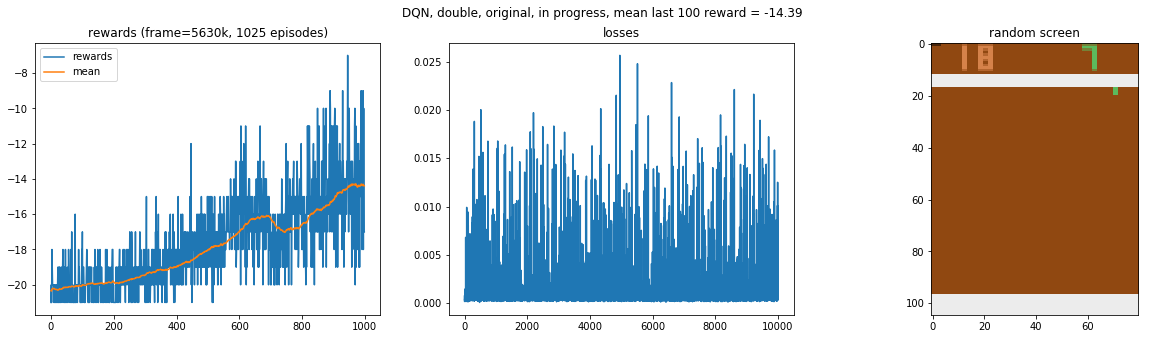

In [ ]:
def build_model():
    return Model(env.observation_space.shape, 4, env.action_space.n).to(device)

def reset_env(env):
    state = env.reset()
    if 'FIRE' in env.unwrapped.get_action_meanings():
        state, _, _, _ = env.step(env.unwrapped.get_action_meanings().index('FIRE'))
    return state

def plot_state(msg):
    clear_output(False)
    plot.figure(figsize=(21,5))
    mean_reward = 0 if len(mean_rewards) < 2 else mean_rewards[-2]
    plot.suptitle(f'DQN, double, original, {msg}, mean last 100 reward = {mean_reward}')
    plot.subplot(131)
    plot.title('rewards (frame=%dk, %d episodes)' % (np.round(frame/1000), episode))
    plot.plot(np.array(all_rewards)[:-1], label='rewards')
    plot.plot(np.array(mean_rewards)[:-1], label='mean')
    plot.legend()
    plot.subplot(132)
    plot.title('losses')
    plot.plot(losses)
    plot.subplot(133)
    plot.title('random screen')
    state, _, _, _, _ = replay.sample(1, device)
    plot.imshow(state.squeeze(0)[-3:].permute(1, 2, 0).cpu().numpy() / 255)
    plot.savefig('state-pong-double-dqn-original.png', format='png')
    plot.show()
    plot.close()

def learn_on_replay():
    target_model.eval()
    model.train()

    states, actions, next_states, rewards, masks = replay.sample(batch_size, device)
    
    q_values = model(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    
    with t.no_grad():
        q_next_values = target_model(next_states)
        if ORIGINAL_DDQN:
            q_next_action = model(next_states).max(1).indices
            q_next_value = q_next_values.gather(1, q_next_action.unsqueeze(1)).squeeze(1)
        else:
            q_next_value = q_next_values.max(1).values
        target = rewards + gamma * (1 - masks) * q_next_value

    loss = loss_fn(q_value, target.detach())

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    
ORIGINAL_DDQN = True
model = build_model()
target_model = build_model()
opt =  t.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = t.nn.SmoothL1Loss()

replay = Replay(int(1e6))
actor = Actor(env, model, eps=1, eps_final=0.01, eps_steps=100000, initial_explore=100000)
all_rewards = collections.deque(maxlen=1000)
mean_rewards = collections.deque(maxlen=1000)
losses = collections.deque(maxlen=10000)
batch_size = 32
gamma = 0.99
frame = 0

for episode in range(10000):
    all_rewards.append(0)
    mean_rewards.append(0)
    state, done = reset_env(env), False
    while not done:
        frame += 1
        action = actor.act(state)
        next_state, reward, done, info = env.step(action)
        all_rewards[-1] += reward
        replay.add(state, action, next_state, reward, done)
        state = next_state

        if len(replay) > batch_size:
            learn_on_replay()
        
        if frame % 1000 == 0:
            target_model.load_state_dict(model.state_dict())
        
        if frame % 10000 == 0:
            plot_state('in progress')

    mean_rewards[-1] = np.mean(np.array(all_rewards)[-100:])
    solved = len(all_rewards) > 100 and mean_rewards[-2] > 18
    if solved:
        break

plot_state('solved' if solved else 'finished')

In [ ]:
if solved:
    import gzip
    with gzip.open('model-pong-double-dqn-orig.gz', 'wb') as f:
        t.save(model.state_dict(), f, pickle_protocol=4)